In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

import random

In [2]:
df = pd.read_csv("./Reviews.csv")
df = df.dropna()
print(len(df))

568401


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df = df.sample(n=int(len(df)*0.02))
print(len(df))

11368


In [5]:
from transformers import pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [6]:
bert_df = df.loc[:,['Text','Score']]
bert_df['Score'] -= 1
train_df, test_df = train_test_split(bert_df, test_size=0.2, random_state=3074)
bert_df.head()

,Text,Score
240845,I just received my first order of the Benecol ...,3
392432,I read lots of reviews on the internet on dry ...,3
64367,"The tea is great. Oddly, one of the sealed 16...",2
268803,"I drink this every single day. It is healthy, ...",4
135580,I don't know a lot about dogs but I thought th...,4


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [8]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df['Text'], 
    add_special_tokens=True,  # the sequences will be encoded with the special tokens relative to our model
    return_attention_mask=True, # return the attention mask according to the specific tokenizer defined by the max_length
    pad_to_max_length=True, 
    # padding=True,
    # truncation=True,
    max_length=256,  # 512 is the maximum for bert model
    return_tensors='pt' # to return PyTorch
)


encoded_data_test = tokenizer.batch_encode_plus(
    test_df['Text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    # padding=True,
    # truncation=True,
    max_length=256, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/mcgregorwang/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df['Score'].to_numpy())

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df['Score'].to_numpy())

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [10]:
import spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
import torch.nn as nn
import torch.nn.functional as F

from transformers import BertConfig, BertModel

nlp = spacy.load('en_core_web_sm')

def get_adj_matrix(input_ids):
    adj_matrix = np.zeros((input_ids.shape[0], input_ids.shape[1], input_ids.shape[1]))

    for i in range(input_ids.shape[0]):
        text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
        doc = nlp(text)
        for token in doc:
            for child in token.children:
                adj_matrix[i, token.i, child.i] = 1

    # print(adj_matrix.shape)

    return torch.from_numpy(adj_matrix).float()


class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads):
        super(GCNLayer, self).__init__()

        self.num_heads = num_heads
        self.linear = nn.Linear(in_channels, out_channels * num_heads)
        self.adj_matrix = None

    def forward(self, x, adj_matrix):
        adj_matrix = adj_matrix.to(x.device)
        self.adj_matrix = adj_matrix

        batch_size, num_nodes, in_channels = x.size()
        out_channels = in_channels

        x = self.linear(x).view(batch_size, num_nodes, self.num_heads * out_channels)
        # x = x.permute(0, 2, 1, 3).contiguous().view(batch_size * self.num_heads, num_nodes, out_channels)

        adj_matrix = adj_matrix + torch.eye(adj_matrix.size(1), device=adj_matrix.device).unsqueeze(0)  # add self-loop
        d = torch.diag_embed(torch.sum(adj_matrix, dim=2))
        d_inv_sqrt = torch.sqrt(torch.linalg.inv(d))
        adj_normalized = torch.bmm(torch.bmm(d_inv_sqrt, adj_matrix), d_inv_sqrt)

        # print(adj_normalized.shape, x.shape)

        x = torch.bmm(adj_normalized, x)
        x = x.view(batch_size, self.num_heads, num_nodes, out_channels).sum(dim=1)

        return F.relu(x)


class BertGCN(nn.Module):
    def __init__(self, num_labels):
        super(BertGCN, self).__init__()
        self.bert_config = BertConfig.from_pretrained('bert-large-uncased')
        print(self.bert_config)
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.gcn_layers = nn.ModuleList([GCNLayer(self.bert_config.hidden_size, self.bert_config.hidden_size, self.bert_config.num_attention_heads) for _ in range(2)])
        # self.linear = nn.Linear(self.bert_config.hidden_size, num_labels)


        in_dim =  self.bert_config.hidden_size
        layers = [nn.Linear(in_dim, 256), nn.ReLU()]
        for _ in range(2 - 1):
            layers += [nn.Linear(256, 256), nn.ReLU()]
        layers += [nn.Linear(256, 128)]
        layers += [nn.Linear(128, num_labels)]

        self.out_mlp = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, adj_matrix):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state

        for gcn_layer in self.gcn_layers:
            hidden = gcn_layer(hidden, adj_matrix)

        logits = self.out_mlp(hidden.mean(dim=1))



        return logits



bert_model = BertGCN(num_labels=5)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
batch_size = 4

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
# DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset
dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=batch_size)

In [13]:
optimizer = AdamW(bert_model.parameters(), lr=1e-5, eps=1e-8)        
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

/Users/mcgregorwang/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [15]:
device = torch.device("mps")

def evaluate(dataloader_val):
    bert_model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        with torch.no_grad():
            outputs = bert_model(batch[0], batch[1], get_adj_matrix(batch[0]))

        loss = criterion(outputs, batch[2])
        logits = outputs
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

f1_scores = []
training_loss = []
validation_loss = []
for epoch in tqdm(range(1, epochs+1)):

    bert_model.train()
    criterion = nn.CrossEntropyLoss()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        bert_model.zero_grad()

        batch = tuple(b.to(device) for b in batch)
        bert_model = bert_model.to(device)


        outputs = bert_model(batch[0], batch[1], get_adj_matrix(batch[0]))
        # print(inputs['labels'])

        loss = criterion(outputs, batch[2])
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(bert_model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.bert_model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_test)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    f1_scores.append(val_f1)
    validation_loss.append(val_loss)
    training_loss.append(loss_train_avg)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2274 [00:00<?, ?it/s]

KeyboardInterrupt: 

Due to the limited performance of the local server, I converted this file to .py and ran in a remote server, the screenshot is as follow:
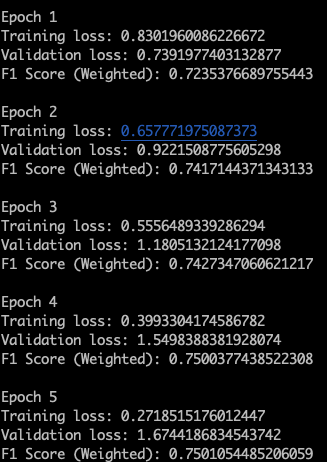